In [67]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time
import random
pd.set_option('display.max_columns', None)
print(sys.version_info)

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


## First: load in the data and do some basic analysis to look for problems

In [3]:
#read in the data
marathon_data = pd.read_csv("data.csv")
marathon_data = marathon_data.dropna()
marathon_data['Time'] = pd.to_timedelta(marathon_data['Time'])
marathon_data.head()

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
0,1,carlos enrique portugal quintero,30,M,1263,04:15:00,09:44,2016
1,2,leonel furlan,60,M,2289,05:05:42,11:41,2016
2,3,meredith gray,30,F,2276,05:04:34,11:38,2016
3,4,jason ainspan,35,M,670,03:52:57,08:53,2015
4,4,jason ainspan,35,M,2390,05:13:30,11:58,2016


In [7]:
marathon_data["Name"].sort_values().head(2)
#We also have this person, who's name is not a valid value

7029    #value! #value!
3175        aaron allen
Name: Name, dtype: object

In [77]:
#There are some people with the age set to 0 
bad_id_list = list(marathon_data[marathon_data["Age Category"] == 0].index)
marathon_data[marathon_data["Age Category"] == 0].shape

(20, 8)

In [78]:
#Gender that is not set to M or F
for temp_id in list(marathon_data[~ marathon_data["Sex"].isin(["M","F"])].index):
    bad_id_list.append(temp_id)
    #add these people to the blacklist
marathon_data[~ marathon_data["Sex"].isin(["M","F"])].shape

(33, 8)

In [82]:
marathon_data.groupby("Name").size().sort_values(ascending = False).head(2)
#Problem with this person

Name
private            347
paul schoenlaub     13
dtype: int64

In [86]:
print(marathon_data.groupby("Id").size().sort_values(ascending = False).head(2))
bad_id_list.append(list(marathon_data.groupby("Id").size().sort_values(ascending = False).head(1).index)[0])
#This is the ID for the private

Id
3327    347
1640     13
dtype: int64


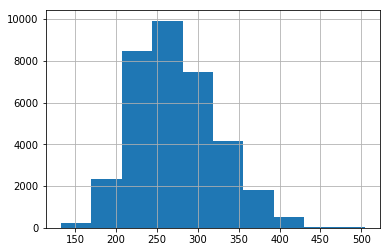

In [38]:
(marathon_data[marathon_data["Year"] != 2013]["Time"] / pd.Timedelta(minutes = 1)).hist()
#Histogram of the finishing times for all years except 2013, in minutes

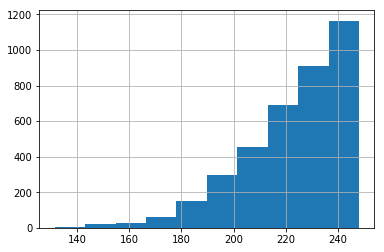

In [133]:
(marathon_data.groupby("Year").get_group(2013)["Time"] / pd.Timedelta(minutes = 0.5)).hist()
#Histogram of the finishing times for 2013, in minutes

In [137]:
rows_2013 = marathon_data[marathon_data["Year"] == 2013].index
marathon_data.loc[rows_2013,"Time"] = marathon_data.loc[rows_2013,"Time"] * 2
#double the times of the half marathon to better fit with the other data
#This is an imperfect solution, but works to a reasonable approximation.. 

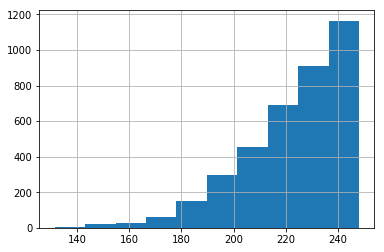

In [138]:
(marathon_data.groupby("Year").get_group(2013)["Time"] / pd.Timedelta(minutes = 1)).hist()

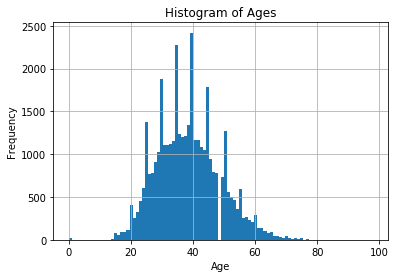

In [20]:
marathon_data["Age Category"].hist(bins = 100)
plt.xlabel("Age")
plt.title("Histogram of Ages")
plt.ylabel("Frequency")
plt.show()

#Note the spikes in frequency of ages at 5-year intervals, starting from 20
#We can see that the age category is a mix of binned and true age data
#However, as the bins are only 5 years apart and teh data is roughly normal, this doesn't present a problem
#We normalize this data to [0,1] later on

In [84]:
marathon_data.sort_values('Time').head()
#This looks good (all the very low times are winners of the race, or close to it)

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
33820,25606,robert mbithi,23,M,1,01:05:44,05:01,2013
31834,23730,danilo briceno,31,M,2,01:10:41,05:23,2013
30990,22939,fornes jose,27,M,3,01:10:57,05:24,2013
31504,23420,leo kormanik ii,30,M,3,01:10:57,05:24,2013
32479,24335,mauricio cruz,17,M,5,01:11:37,05:28,2013


## Now, we have clean data but need to extract the features for our models

In [121]:
data_pivot = pd.pivot_table(marathon_data, index = ["Id"], columns = "Year", values = ["Rank","Age Category", "Time"], aggfunc= "first")

data_pivot["Num Marathons"] = data_pivot.apply(lambda x: x.iloc[0:14].count() , axis = 1)
for yr in marathon_data.groupby('Year').groups:
    print("Number attending in " + str(yr) + " who also attended in other years = " + str(sum(data_pivot.loc[np.invert(pd.isnull(data_pivot["Rank"][yr]))]["Num Marathons"].apply(lambda x: 1 if x > 1 else 0))))

Number attending in 2016 who also attended in other years = 793
Number attending in 2003 who also attended in other years = 502
Number attending in 2004 who also attended in other years = 679
Number attending in 2005 who also attended in other years = 692
Number attending in 2006 who also attended in other years = 780
Number attending in 2007 who also attended in other years = 850
Number attending in 2008 who also attended in other years = 864
Number attending in 2009 who also attended in other years = 1021
Number attending in 2010 who also attended in other years = 1093
Number attending in 2011 who also attended in other years = 1232
Number attending in 2012 who also attended in other years = 1254
Number attending in 2013 who also attended in other years = 752
Number attending in 2014 who also attended in other years = 1085
Number attending in 2015 who also attended in other years = 882


In [139]:
data_pivot = pd.pivot_table(marathon_data, index = ["Id"], columns = "Year", values = ["Rank","Age Category", "Time"], aggfunc= "first")
#A pivot table reshapes the data to be one row per person

def create_frame(last_year):
    start = time.time()
    
    #This is the function to create a frame with the relavant features for each runner, given a year
    #The basic process is we create a pandas pivot table to help us, then we iterate over this pivot table (mostly using apply)
    #to create a new pandas dataframe (new_frame) that contains all relavent features 
    
    #the year we input (last_year) is the last year that we look at (1 year back from current)
    #IE, if we are looking to train a model to predict for 2017, we would give 2015 as the last_year, and the features would include all years up to 2015
    #Then, to predict for 2017 we input 2016 to include features
    
    new_frame = pd.DataFrame(data = {"Id": marathon_data.Id, "Sex": marathon_data.Sex})
    new_frame = new_frame.drop_duplicates("Id")
    new_frame["Sex"] = pd.get_dummies(new_frame["Sex"])
    #1 is male, 0 is female
    
    new_frame.index = new_frame.Id
    
    #helper functions
    def lastfilled(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key-1
            #if (key == 2013):
            #    key = key - 1
            if (key < 2003): 
                return None 
        return (last_year - key + 1)
        
    def valuelast(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key - 1
            #if (key == 2013):
            #    key = key - 1
            if (key < 2003): 
                return None
        return row.loc[key]
    
    for i in range(0,(last_year - 2002)):
        #Here we iterate over the relavent columns in order to get the dummies for participation
        #Each column will be a boolean variable, with a 1 if the runner participated that year, and a 0 otherwise
        #the output is expressed in terms of lags: IE, Lag_1 is one year ago, Lag_4 is 4 years ago...
        new_frame["_".join(("Lag",str(i + 1)))] = pd.isnull(data_pivot["Rank"]).iloc[:,(last_year - 2003 - i)].apply(lambda x: 0 if x else 1)

    new_frame["Num Marathons"] = data_pivot.apply(lambda x: x.iloc[0:(last_year - 2002)].count() , axis = 1)
    #number of marathons ran
    new_frame["Years Since Last"] = data_pivot.apply(lambda x: lastfilled(x["Rank"]), axis = 1)
    #years since last ra 
    new_frame["Time of Last"] = data_pivot.apply(lambda x: valuelast(x["Time"]), axis = 1)
    #time of the last marathon they competed in 
    new_frame["Age Last"] = data_pivot.apply(lambda x: valuelast(x["Age Category"]), axis = 1)
    #NOTE: these apply functions are very time-costly. It takes around 60seconds to run this function fully
    
    #Normalization on the time and age columns
    new_frame["Time of Last"] = (new_frame["Time of Last"] - new_frame["Time of Last"].min()) / (new_frame["Time of Last"].max() - new_frame["Time of Last"].min())
    new_frame["Age Last"] = (new_frame["Age Last"] - new_frame["Age Last"].min()) / (new_frame["Age Last"].max() - new_frame["Age Last"].min())
    
    new_frame["Dummy"] = np.ones(len(new_frame))
    
    del new_frame["Id"]
    
    print(time.time() - start)
    return new_frame

## Now: Logistic Regression 

As logistic regression is a supervised learning model, we need to train the model using a y-vector of instances of correct categorization that we have. This is acomplished by using 2016 as our  categorization year, and using as our features set the data on participation in races from 2003 to 2015. In this case, we exclude all participants who do not have a race between 2003 and 2015 (those who only race in 2016). 

In [140]:
##Here is where we perform the gradient descent
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def error_fxn(w_vect, x_array, y_vect):
    #This function computes the error function, given a weights vector w_vect
    #This allow us to call this function repeatedly as we optimize the w_vect through gradient descent
    y0 = np.log(sigmoid(x_array.dot(w_vect))).dot(y_vect)
    y1 = np.log(1 - sigmoid(x_array.dot(w_vect))).dot(1-y_vect)
    return -(y0 + y1) / len(y_vect)

def grad_fxn(w_vect, x_array, y_vect): 
    #This function computes the gradient function, given the weights vector w_vect
    return (y_vect - sigmoid(np.dot(x_array, w_vect))).dot(x_array)

def grad_descent(w_vect, x_array, y_vect, step, tol, maxi, alpha = 0.5, print_out = True):
    start = time.time()
    #performs the gradient descent
    grad_history = [[w_vect, error_fxn(w_vect, x_array, y_vect)]]
    #store all the past values of the w vector and the error function
    #(we use this to plot the gradient descent or diagnose problems)
    delta = grad_history[0][1]
    delta = 1
    i = 0
    stepi = step
    while(delta > tol): 
        #We continue the descent until the change in error (delta) is less than our tolerance parameter (tol)
        w_old = w_vect
        w_vect = w_old + stepi * grad_fxn(w_old, x_array, y_vect)
        grad_history.append([w_vect, error_fxn(w_vect, x_array, y_vect)])
        delta =  grad_history[-2][1] - grad_history[-1][1]
        stepi = step / (alpha*i + 1)
        #we decrease the step each time to help with convergence
        i = i + 1
        if(i > maxi):
            #We want to end the loop if it has run for two long without converging
            break
    if(print_out):
        print("Loops run = " + str(i))
        print("Time = " + str(time.time() - start))
        print("Exit delta = " + str(delta))
        print("Exit Error = " + str(error_fxn(w_vect, x_array, y_vect)))
        plt.plot([i[1] for i in grad_history])
        plt.title("Gradient Descent")
        plt.xlabel("Iteration")
        plt.ylabel("Error")
        plt.show()
        
    return w_vect, grad_history

In [141]:
#plot the gradient descent
#We are plotting the cost function (y-axis) of each iteration
#against the value of one position of the w-vector for that iteration

def plot_grads(grad_history):
    errs = [i[1] for i in grad_history]
    nrows = 5
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize = (10,10))
    j = 0

    for ax in axes.reshape(-1): 
        ax.plot([i[0][j] for i in grad_history], errs)
        j = j+1
        if(j >= len(grad_history[0][0])):
            break

# Train on pre-2015 to get accuracy of model on 2016

In [142]:
def get_y(year, index): 
    tempy = pd.isnull(data_pivot["Rank"]).iloc[:,((year - 2003))].apply(lambda x: 0 if x else 1)
    tempy = tempy.loc[index]
    return tempy.as_matrix()
#The other component that we need is our y-vector, which is the participation boolean for 2016

def predict_y(w_vect, x_array): 
    prob_y1 = sigmoid(x_array.dot(w_vect))
    #probability
    part_y = np.where(prob_y1 > 0.5, 1, 0)
    #participation
    return part_y

def prediction_stats_print(y_pred, y_vect):
    #y_pred is the vector of predicted y
    #y_vect is the vector of actual values for y 
    
    #prints out the relavent prediction stats
    ac = sum(np.invert(np.logical_xor(y_vect, y_pred))) / len(y_vect)
    naive_ac = 1 - sum(y_vect) / len(y_vect)
    tpos = sum(y_pred * y_vect)
    sensitivity = tpos / sum(y_vect)
    specificity = (len(y_vect) - sum(np.logical_or(y_vect, y_pred))) / (len(y_vect) - sum(y_vect))
    
    print("Predicted Y1 = " + str(sum(y_pred)))
    print("Accuracy = " + str(ac))
    print("Naive Accuracy = " + str(naive_ac))
    print("Sensitivity = " + str(sensitivity))
    print("Specificity = " + str(specificity))
    
def prediction_stats(y_pred, y_vect):
    #y_pred is the vector of predicted y
    #y_vect is the vector of actual values for y 
    #returns prediction_stats in a list form
    ac = sum(np.invert(np.logical_xor(y_vect, y_pred))) / len(y_vect)
    naive_ac = 1 - sum(y_test) / len(y_vect)
    tpos = sum(y_pred * y_vect)
    sensitivity = tpos / sum(y_vect)
    specificity = (len(y_vect) - sum(np.logical_or(y_vect, y_pred))) / (len(y_vect) - sum(y_vect))
    
    return [ac, sensitivity, specificity]

In [143]:
train_df = create_frame(2014)
#remove entries where there are no races
train_df = train_df[train_df["Num Marathons"] > 0]
train_df = train_df[~ train_df.index.isin(bad_id_list)]
del train_df["Years Since Last"]
train_array = train_df.as_matrix()
train_array.shape

77.13384199142456


(26136, 17)

In [144]:
test_df = create_frame(2015)
test_df = test_df[test_df["Num Marathons"] > 0 ]
del test_df["Years Since Last"]
del test_df["Lag_12"]
test_array = test_df.as_matrix()

78.51866912841797


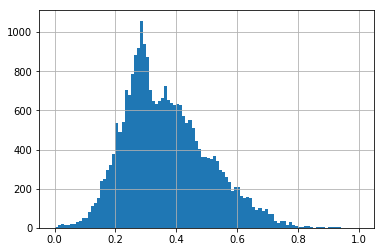

In [145]:
train_df["Time of Last"].hist(bins = 100)

In [146]:
y_vect = get_y(2015, train_df.index)

In [ ]:
my_w, grad_history = grad_descent(w_vect = np.zeros(train_array.shape[1]), 
                                  x_array = train_array, y_vect = y_vect, 
                                  step = 1e-4, tol = 1e-10, maxi = 10000, alpha = 0)

In [ ]:
my_w

In [ ]:
plot_grads(grad_history)

In [ ]:
#Accuracy on 2016 predictions
y_test = get_y(2016, test_df.index)
y_pred = predict_y(my_w, test_array)
prediction_stats_print(y_pred, y_test)

## Cross Validate the step sizes

In [ ]:
def get_results(test_year, step, tol, alpha, maxi): 
    #function wrapper that returns the predictions for a given test year, given gradient descent parameters
    #to allow us to iterate over these parameters
    
    my_w, grad_history = grad_descent(w_vect = np.zeros(train_array.shape[1]), 
                                  x_array = train_array, y_vect = y_vect, 
                                  step = step, tol = tol, maxi = maxi, alpha = alpha, print_out = False)
    
    y_pred = predict_y(my_w, test_array)
    return prediction_stats(y_pred, y_test)
    

In [ ]:
alpha_list = np.linspace(0,1,11)
results_list = []

train_df = create_frame(2014)
#remove entries where there are no races
train_df = train_df[train_df["Num Marathons"] > 0]
train_df = train_df[~ train_df.index.isin(bad_id_list)]
#delete the bad IDs from our training data
del train_df["Years Since Last"]
train_df = train_df[train_df]
train_array = train_df.as_matrix()

test_df = create_frame(2015)
test_df = test_df[test_df["Num Marathons"] > 0 ]
del test_df["Years Since Last"]
del test_df["Lag_12"]
test_array = test_df.as_matrix()

y_vect = get_y(2015, train_df.index)
y_test = get_y(2016, test_df.index)

In [ ]:
#Here, we iterate over the values of alpha, collecting the accuracy of each iteration 
#We can then use this to determine the optimal value of alpha
alpha_list = np.linspace(0.001,.01,10)
results_list = []

i = 0
for alph in alpha_list:
    start = time.time()
    my_w, grad_history = grad_descent(w_vect = np.zeros(train_array.shape[1]), 
                                  x_array = train_array, y_vect = y_vect, 
                                  step = 1e-4, tol = 1e-8, maxi = 10000, alpha = alph, print_out = False)
    y_pred = predict_y(my_w, test_array)
    results_list.append([alph, prediction_stats(y_pred, y_test)])
    print("i = " + str(i) + ", time of loop = " + str(time.time() - start))
    i = i + 1

In [ ]:
results_list

In [ ]:
#Lets try k-fold cross validation.
#First, we will just perform the cross validation to get an idea of the out-of-sample accuracy of the model,
#Then, we will do the cross validation with a hyperparameter of the tolerance in the gradient descent 

y_df = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)


k_train_index = random.sample(list(train_df.index),int(np.floor(len(train_df)*0.8)))
#Train on 80% of the data (~20k rows)
k_train_array= train_df.loc[k_train_index].as_matrix()
not_df = train_df.index.isin(k_train_index)
k_test_df = train_df[~not_df]
k_test_array = k_test_df.as_matrix()
#Test with the remaining 20% (~5k rows)

k_y_train = y_df.loc[k_train_index].as_matrix()
#training y-vector
k_y_test = y_df.loc[k_test_df.index].as_matrix()
#testing y-vector

k_w, k_hist = grad_descent(w_vect = np.zeros(train_array.shape[1]), x_array = k_train_array, 
                           y_vect = k_y_train, step = 1e-4, tol = 1e-6, maxi = 10000, print_out = False)

k_y_pred_train = predict_y(k_w, k_train_array)

k_insample = ratio_predicted(k_y_pred_train, k_y_train)

print()
print("In Sample = " + str(k_insample))
print("Naive in sample = " + str((1 - sum(k_y_train)/ len(k_y_train))))
print()

#Now, let's look at the out of sample! 

k_y_pred_test = predict_y(k_w, k_test_array)
k_oos = ratio_predicted(k_y_pred_test, k_y_test)

print("Out of Sample = " + str(k_oos))
print("Naive Out of Sample = " + str((1 - sum(k_y_test)/ len(k_y_test))))

In [ ]:
#Lets try k-fold cross validation.

#TODO: prevent the different folds from overlapping
#This is actually bootstrapping rather than k-fold 

#First, we will just perform the cross validation to get an idea of the out-of-sample accuracy of the model,
#Then, we will do the cross validation with a hyperparameter of the tolerance in the gradient descent 

y_df = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)

train_df_rand = train_df.reindex(np.random.permutation(train_df.index))
#reindex the dataframe in random order


#Randomize rows at beginning, then take the first 
def kfold(k):
    start = time.time()
    accuracy = []
    
    for i in range(1,k):
        k_train_index = random.sample(list(train_df.index),int(np.floor(len(train_df)*0.8)))
        #Train on 80% of the data (~20k rows)
        k_train_array= train_df.loc[k_train_index].as_matrix()
        not_df = train_df.index.isin(k_train_index)
        k_test_df = train_df[~not_df]
        k_test_array = k_test_df.as_matrix()
        #Test with the remaining 20% (~5k rows)

        k_y_train = y_df.loc[k_train_index].as_matrix()
        #training y-vector
        k_y_test = y_df.loc[k_test_df.index].as_matrix()
        #testing y-vector

        k_w, k_hist = grad_descent(w_vect = np.zeros(train_array.shape[1]), x_array = k_train_array, 
                                   y_vect = k_y_train, step = 1e-4, tol = 1e-6, maxi = 10000, print_out = False)

        k_y_pred_train = predict_y(k_w, k_train_array)

        k_insample = ratio_predicted(k_y_pred_train, k_y_train)

    #     print()
    #     print("In Sample = " + str(k_insample))
    #     print("Naive in sample = " + str((1 - sum(k_y_train)/ len(k_y_train))))
    #     print()

        #Now, let's look at the out of sample! 

        k_y_pred_test = predict_y(k_w, k_test_array)
        k_oos = ratio_predicted(k_y_pred_test, k_y_test)
        k_oos_naive = (1 - sum(k_y_test)/ len(k_y_test))
        accuracy.append((k_oos / k_oos_naive))

    #     print("Out of Sample = " + str(k_oos))
    #     print("Naive Out of Sample = " + str(k_oos_naive)
    print("Time Taken = " + str(time.time() - start))
    print("Average Accuracy Above Naive = " + str(np.mean(accuracy)))

In [ ]:
train_df.loc[[3327]]

In [ ]:
train_df = train_df[train_df.index != 3327]

In [ ]:
train_df.loc[[3327]]